Разница с предыдущей версией проекта лишь в том, что теперь мы срезаем с модели выходной слой

In [0]:
#!pip install tensorflow==1.14.0
%tensorflow_version 1.14
import tensorflow
print(tensorflow.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [0]:
from google.colab import drive 
from zipfile import ZipFile

drive.mount('/content/gdrive', force_remount=True)
!cp -r /content/gdrive/'My Drive'/train.zip .

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
with ZipFile("train.zip", 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
import pandas as pd
from glob import glob
import os
from PIL import Image
import numpy as np
import random
from tqdm import tqdm

import xgboost as xgb
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
random.seed(34)

Using TensorFlow backend.


In [0]:
resnet = ResNet50(weights='imagenet', include_top=False)

In [0]:
def read_dataset(path, size_batch, num_batch):
    X = []
    y = []
    image_paths_list = glob(os.path.join(path, 'train', '*.jpg'))
    for i in tqdm(range(num_batch)):
      #choose 1000 random samples and then throw out selected images from image_paths_list
      image_paths_sample = random.sample(image_paths_list, size_batch)
      image_paths_list = list(set(image_paths_list) - set(image_paths_sample))
      for image_path in image_paths_sample:
          image_name = os.path.basename(image_path)
          image_name_parts = image_name.split('.')
          label = image_name_parts[0] if len(image_name_parts) == 3 else None

          if label:
              y.append(int(label == 'cat'))
    
          x = image.img_to_array(image.load_img(image_path, target_size=(224, 224)))
          x = np.expand_dims(x, axis=0)
          x = preprocess_input(x)
          resnet_feature = resnet.predict(x)
          resnet_feature_np = np.array(resnet_feature)
          #print(resnet_feature_np.shape)
          X.append(resnet_feature_np.flatten())
                
    return np.array(X), y

In [0]:
features, labels = read_dataset('', 1000, 3) #path='data/' 
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)
print(x_train.shape)

In [0]:
%%time
clf = xgb.XGBClassifier()
clf.fit(x_train, y_train)

score_train = clf.score(x_train, y_train)
score_test = clf.score(x_test, y_test)
print(score_train, score_test)
#get 96.44 on test with standard parametres, 8min

1.0 0.9644444444444444
CPU times: user 7min 48s, sys: 170 ms, total: 7min 48s
Wall time: 7min 48s


In [0]:
from hyperopt import hp, tpe, Trials, STATUS_OK, fmin
from sklearn.metrics import roc_auc_score

SEED = 314159265

def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)
    watchlist = [(dtest, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    predictions = gbm_model.predict(dtest,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_test, predictions)
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


def optimize(
             #trials, 
             random_state=SEED):
    space = {
        'n_estimators': 200,
        'learning_rate': 0.3,
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state
    }
    best = fmin(score, space, algo=tpe.suggest, max_evals=15)
    return best

best_hyperparams = optimize()
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

In [0]:
%%time
clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.3, colsample_bytree=0.9500000000000001, gamma=0.6000000000000001, max_depth=3, min_child_weight=2.0, subsample=0.8500000000000001)
clf.fit(x_train, y_train)

score_train = clf.score(x_train, y_train)
score_test = clf.score(x_test, y_test)
print(score_train, score_test)
#get 0.9711

1.0 0.9711111111111111
CPU times: user 13min 24s, sys: 2.66 s, total: 13min 26s
Wall time: 13min 27s


n=106, Accuracy: 0.97222
CPU times: user 1.61 s, sys: 19 ms, total: 1.63 s
Wall time: 1.63 s


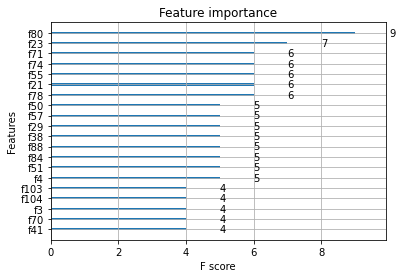

In [0]:
%%time
from sklearn.feature_selection import SelectFromModel
from xgboost import plot_importance

selection = SelectFromModel(clf, threshold=0.001, prefit=True)
select_x_train = selection.transform(x_train)

selection_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.3, colsample_bytree=0.9500000000000001, gamma=0.6000000000000001, max_depth=3, min_child_weight=2.0, subsample=0.8500000000000001)
selection_model.fit(select_x_train, y_train)

select_x_test = selection.transform(x_test)
y_pred = selection_model.predict(select_x_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("n=%d, Accuracy: %.5f" % (select_x_train.shape[1], accuracy))
plot_importance(selection_model, max_num_features=20)